In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
stock_data = pd.read_csv("/content/drive/MyDrive/final_data.csv")
stock_data  = stock_data [stock_data ['date'].between('2009-01-01', '2024-12-31')]

In [5]:
id_col = ["PERMNO", 'CUSIP', 'Ticker', 'SICCD','NAICS']
time_col = ['MthCalDt']
factor_col = ['mom_12','mom_6', 'vol_12', 'vol_6', 'rev_1', 'rvol_1',"rsi_6", 'trend_strength']
market_col = [ 'qmj_safety','seas_11_15na',
              'ret_3_1', 'iskew_ff3_21d', 'rskew_21d', 'sti_gr1a','earnings_variability', 'nfna_gr1a',
              'seas_16_20an', 'corr_1260d']
fin_col = ['capxy', 'chechy', 'cshfdy', 'cshpry', 'dltry', 'dpcy',
       'epspxy', 'oibdpy', 'txty']

In [24]:
def prepare_data_simple(df, sequence_length=12, fin_col=fin_col, factor_col=factor_col, market_col=market_col):
    """Prepare data (simplified version)"""

    feature_cols = fin_col + factor_col + market_col

    # Ensure data is sorted by stock and date
    df_sorted = df.sort_values(['PERMNO', 'date']).reset_index(drop=True)

    print("\nStep 1: Standardizing all feature data...")
    all_features = df_sorted[feature_cols].values
    scaler = StandardScaler()
    all_features_scaled = scaler.fit_transform(all_features)

    df_with_scaled_features = df_sorted.copy()
    df_with_scaled_features[feature_cols] = all_features_scaled

    print(f"Standardization completed, feature shape: {all_features_scaled.shape}")

    print("\nStep 2: Transforming stock data into time series...")
    X_3d = []
    y_3d = []
    date_3d = []
    stock_3d = []

    stock_count = 0
    valid_sequences = 0

    for permno, group in df_with_scaled_features.groupby('PERMNO'):
        group = group.sort_values('date').reset_index(drop=True)
        stock_count += 1

        if len(group) < sequence_length + 1:
            continue

        # Extract standardized features and targets for this stock
        stock_features_scaled = group[feature_cols].values  # already standardized
        stock_targets = group['pred_cat'].values
        stock_dates = group['date'].values

        # Create sliding windows for this stock
        for i in range(sequence_length, len(group)):
            # Features: use standardized features from period i-sequence_length to i-1
            X_sequence = stock_features_scaled[i-sequence_length:i]
            # Target: use pred_cat from period i
            y_target = stock_targets[i]

            # Check if target variable is valid
            if not np.isnan(y_target):
                X_3d.append(X_sequence)
                y_3d.append(y_target)
                date_3d.append(stock_dates[i])
                stock_3d.append(permno)
                valid_sequences += 1

    X_3d = np.array(X_3d)
    y_3d = np.array(y_3d)
    date_3d = np.array(date_3d)
    stock_3d = np.array(stock_3d)

    print(f"Time series transformation completed!")

    # Step 3: Re-sort all samples by time
    print("\nStep 3: Re-sorting by time...")
    time_sort_idx = np.argsort(date_3d)
    X_3d = X_3d[time_sort_idx]
    y_3d = y_3d[time_sort_idx]
    date_3d = date_3d[time_sort_idx]
    stock_3d = stock_3d[time_sort_idx]

    print(f"Time sorting completed!")
    print(f"\nFinal data statistics:")
    print(f"Total stocks: {stock_count}")
    print(f"Valid sequences: {valid_sequences}")
    print(f"Final sample count: {X_3d.shape[0]}")
    print(f"Sequence length: {X_3d.shape[1]}")
    print(f"Feature count: {X_3d.shape[2]}")
    print(f"Time range: {date_3d[0]} to {date_3d[-1]}")
    print(f"Number of unique stocks: {len(np.unique(stock_3d))}")

    # Validate time sorting
    print(f"\nTime sorting validation:")
    is_time_sorted = np.all(date_3d[:-1] <= date_3d[1:])
    print(f"Is data sorted by time: {is_time_sorted}")
    if not is_time_sorted:
        print("Warning: Data is not correctly sorted by time!")
    else:
        print(" Data is correctly sorted by time")

    # Validate standardization
    print(f"\nStandardization validation:")
    feature_means = X_3d.reshape(-1, X_3d.shape[-1]).mean(axis=0)
    feature_stds = X_3d.reshape(-1, X_3d.shape[-1]).std(axis=0)
    print(f"Feature mean range: [{feature_means.min():.6f}, {feature_means.max():.6f}]")
    print(f"Feature std range: [{feature_stds.min():.6f}, {feature_stds.max():.6f}]")

    return X_3d, y_3d.astype(int), date_3d, stock_3d, scaler

def time_split_data(X, y, dates, stocks, train_ratio=0.7, val_ratio=0.15):
    """
    Split data by time (considering stock information)
    """
    # Sort all samples by date
    sort_idx = np.argsort(dates)
    X_sorted = X[sort_idx]
    y_sorted = y[sort_idx]
    dates_sorted = dates[sort_idx]
    stocks_sorted = stocks[sort_idx]

    n_samples = len(X_sorted)
    train_end = int(n_samples * train_ratio)
    val_end = int(n_samples * (train_ratio + val_ratio))

    X_train = X_sorted[:train_end]
    X_val = X_sorted[train_end:val_end]
    X_test = X_sorted[val_end:]

    y_train = y_sorted[:train_end]
    y_val = y_sorted[train_end:val_end]
    y_test = y_sorted[val_end:]

    print(f"\nDataset split:")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Training set time range: {dates_sorted[0]} to {dates_sorted[train_end-1]}")
    print(f"Validation set time range: {dates_sorted[train_end]} to {dates_sorted[val_end-1]}")
    print(f"Test set time range: {dates_sorted[val_end]} to {dates_sorted[-1]}")

    # Count unique stocks in each set
    print(f"Training set unique stocks: {len(np.unique(stocks_sorted[:train_end]))}")
    print(f"Validation set unique stocks: {len(np.unique(stocks_sorted[train_end:val_end]))}")
    print(f"Test set unique stocks: {len(np.unique(stocks_sorted[val_end:]))}")

    return X_train, X_val, X_test, y_train, y_val, y_test

def create_simple_model(input_shape, num_classes=2):
    """
    Create a simple and fast CNN+LSTM model
    """
    model = Sequential([
        # Simplified CNN layer: only one layer
        Conv1D(filters=16, kernel_size=3, activation='relu',
               input_shape=input_shape, padding='same'),
        Dropout(0.2),  # Add dropout

        # Simplified LSTM layer: reduced units
        LSTM(16, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),

        # Simplified classification layer
        Dense(8, activation='relu'),
        Dropout(0.3),  # Higher dropout
        Dense(1 if num_classes == 2 else num_classes,
              activation='sigmoid' if num_classes == 2 else 'softmax')
    ])

    return model

def train_model(X_train, y_train, X_val, y_val, num_classes=2):
    """
    Train the model
    """
    # Create model
    model = create_simple_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=num_classes
    )

    # Compile model
    if num_classes == 2:
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    else:
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    print("\nModel architecture:")
    model.summary()

    # Set up callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # Train model
    print("\nStart training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Fewer epochs for faster training
        batch_size=256,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model
    """
    # Predict
    y_pred_proba = model.predict(X_test)
    if y_pred_proba.shape[1] == 1:  # Binary classification sigmoid output
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    else:  # Multi-class softmax output
        y_pred = np.argmax(y_pred_proba, axis=1)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest accuracy: {accuracy:.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    return y_pred, y_pred_proba

# Complete training pipeline
def run_complete_pipeline(df, sequence_length=20):
    """
    Complete training pipeline
    """
    # 1. Data preparation
    X, y, dates, stocks, scaler = prepare_data_simple(df, sequence_length)

    # 2. Time-based split
    X_train, X_val, X_test, y_train, y_val, y_test = time_split_data(
        X, y, dates, stocks, train_ratio=0.7, val_ratio=0.15
    )

    # 3. Check number of classes
    num_classes = len(np.unique(y))
    print(f"\nNumber of classes: {num_classes}")
    print(f"Class distribution: {np.bincount(y)}")

    # 4. Train model
    model, history = train_model(X_train, y_train, X_val, y_val, num_classes)

    # 5. Evaluate model
    y_pred, y_pred_proba = evaluate_model(model, X_test, y_test)

    return model, history, scaler, (X_train, X_val, X_test, y_train, y_val, y_test)

In [25]:
# Usage Example
if __name__ == "__main__":
    # Assume your data is already loaded as df
    # df = pd.read_csv('your_data.csv')

    # Run complete pipeline
    model, history, scaler, data_splits = run_complete_pipeline(stock_data, sequence_length=12)

    # Save model
    # model.save('stock_prediction_model.h5')

    print("\nTraining completed!")


第一步：标准化所有特征数据...
标准化完成，特征形状: (1286513, 27)

第二步：按股票升维为时间序列...
升维完成!

第三步：按时间重新排序...
时间排序完成!

最终数据统计:
总股票数: 15045
有效序列数: 1115706
最终样本数量: 1115706
序列长度: 12
特征数量: 27
时间范围: 2009-02-27 到 2024-12-31
涉及股票数: 13233

时间排序验证:
数据是否按时间排序: True
✅ 数据已正确按时间排序

标准化验证:
特征均值范围: [-0.035892, 0.034067]
特征标准差范围: [0.847246, 1.072608]

数据集划分:
训练集: 780994 样本
验证集: 167356 样本
测试集: 167356 样本
训练集时间范围: 2009-02-27 到 2021-01-29
验证集时间范围: 2021-01-29 到 2023-02-28
测试集时间范围: 2023-02-28 到 2024-12-31
训练集股票数: 10353
验证集股票数: 8128
测试集股票数: 8664

类别数量: 2
类别分布: [516673 599033]

模型结构:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 12, 16)         │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,569 (13.94 KB)

 Trainable params: 3,569 (13.94 KB)

 Non-trainable params: 0 (0.00 B)


开始训练...
Epoch 1/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 92s 29ms/step - accuracy: 0.5866 - loss: 0.6662 - val_accuracy: 0.4835 - val_loss: 0.7221 - learning_rate: 0.0010
Epoch 2/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 87s 29ms/step - accuracy: 0.6488 - loss: 0.6278 - val_accuracy: 0.4968 - val_loss: 0.7220 - learning_rate: 0.0010
Epoch 3/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 87s 29ms/step - accuracy: 0.6566 - loss: 0.6202 - val_accuracy: 0.5172 - val_loss: 0.7181 - learning_rate: 0.0010
Epoch 4/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 88s 29ms/step - accuracy: 0.6600 - loss: 0.6159 - val_accuracy: 0.5370 - val_loss: 0.7073 - learning_rate: 0.0010
Epoch 5/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 87s 29ms/step - accuracy: 0.6625 - loss: 0.6132 - val_accuracy: 0.5574 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 6/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 88s 29ms/step - accuracy: 0.6646 - loss: 0.6110 - val_accuracy: 0.5559 - val_loss: 0.7000 - learning_rate: 0.0010
Epoch 7/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 88s 29ms/step

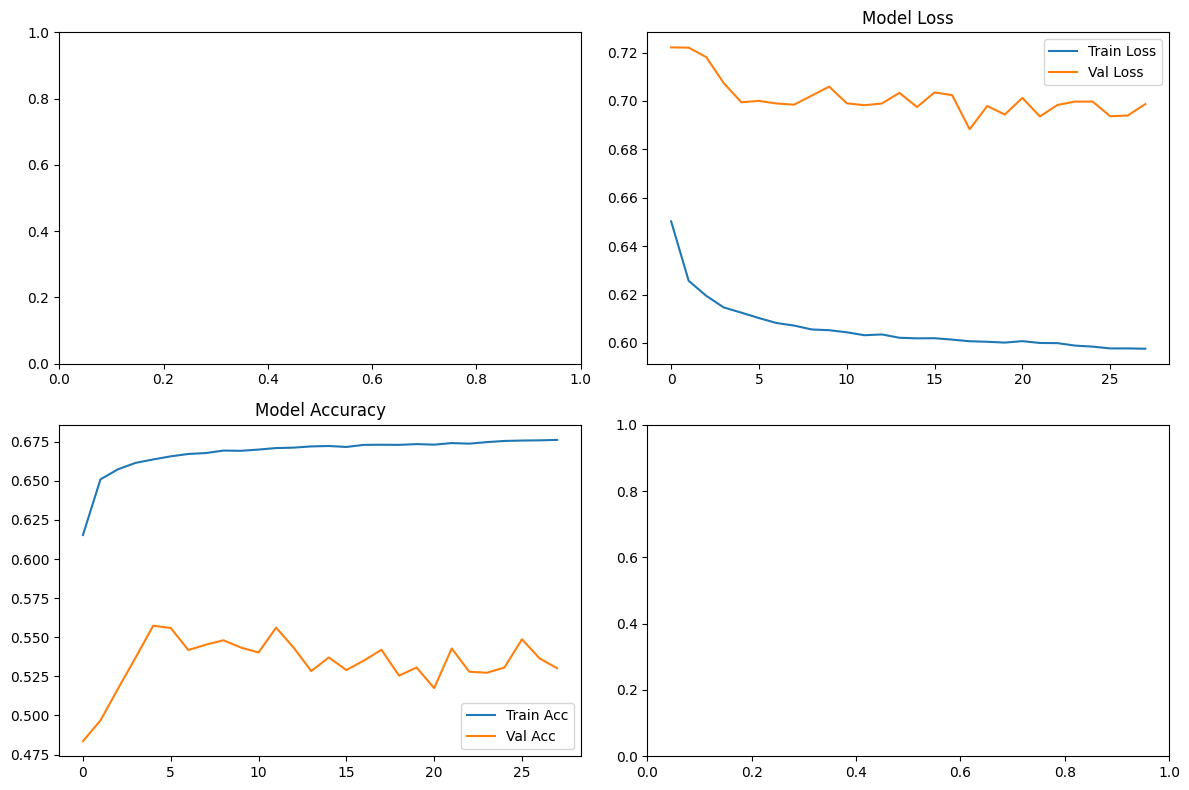

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    if "auc" in history.history:
      axes[0,0].plot(history.history['auc'], label='Train AUC')
      axes[0,0].plot(history.history['val_auc'], label='Val AUC')
      axes[0,0].set_title('Model AUC')
      axes[0,0].legend()

    axes[0,1].plot(history.history['loss'], label='Train Loss')
    axes[0,1].plot(history.history['val_loss'], label='Val Loss')
    axes[0,1].set_title('Model Loss')
    axes[0,1].legend()

    axes[1,0].plot(history.history['accuracy'], label='Train Acc')
    axes[1,0].plot(history.history['val_accuracy'], label='Val Acc')
    axes[1,0].set_title('Model Accuracy')
    axes[1,0].legend()

    if "precision" in history.history:
      axes[1,1].plot(history.history['precision'], label='Train Precision')
      axes[1,1].plot(history.history['val_precision'], label='Val Precision')
      axes[1,1].set_title('Model Precision')
      axes[1,1].legend()

    if 'lr' in history.history:
        axes[1,1].plot(history.history['lr'])
        axes[1,1].set_title('Learning Rate')
        axes[1,1].set_yscale('log')

    plt.tight_layout()
    plt.show()
    plt.savefig("DNN.jpg")

plot_training_history(history)